# Object Detection notebook
## CS152 October 2, 2018  Neil Rhodes

We look at Object Detection

Code based on [fastai style transfer notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/style-transfer.ipynb).

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We are interested in finding objects and their bounding boxes within images.


In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *

from fastai.sgdr import *
from fastai.plots import *

import collections
import json
from matplotlib import patheffects, patches
import pandas as pd
from pathlib import Path

/home/nrhodes/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Utility Functions

In [3]:
def denorm(tensor, denormalizer):
    """Does the opposite of the transformation from tfms_from_model"""
    
    # Even though the transformer returned from tfms_from_model moves the channels
    # (from width, height, depth) to (1, channels, width, height), the denormalizer
    # returned from tfms_from_model doesn't convert back
    wid_height_depth = np.moveaxis(to_np(tensor),1,-1)[0]
    return denormalizer(wid_height_depth)

In [4]:
def draw_with_size(image, size_in_inches):
    plt.figure(figsize=(size_in_inches, size_in_inches))
    plt.imshow(image);

# Getting the data

We'll be using the Pascal dataset, downloaded from XXX

In [5]:
PATH = Path('../../data/pascal')
TRAIN_JSON = 'pascal_train2007.json'
VAL_JSON = 'pascal_val2007.json'

In [6]:
with (PATH/TRAIN_JSON).open() as f:
    dict_train = json.load(f)
dict_train.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [7]:
IMAGES, _, ANNOTATIONS, CATEGORIES  = dict_train.keys()

In [8]:
id_to_image_info = {
    f['id']: {
        'file': f['file_name'], 
        'height': f['height'],
        'width': f['width'] 
    } for f in dict_train[IMAGES]}

We'll use (left, top, right, bottom) for our bounding box coordinates.  VOC uses (top, left, height, width). These are conversions

In [9]:
def voc_to_bb(bb):
    top, left, height, width = bb
    return (left, top, left + width, top + height)

def bb_to_voc(voc):
    left, top, right, bottom = voc
    return (top, left, bottom - top, right - left)

In [10]:
images = collections.defaultdict(list)
for annotation in dict_train[ANNOTATIONS]:
    bbox = annotation['bbox']
    image_info = id_to_image_info[annotation['image_id']]
    images[image_info['file']].append(
        {
            'bb': voc_to_bb(bbox),
            'category': annotation['category_id']
        })
images = dict(images) # Once we've created it, we don't want defaultdict behavior

In [11]:
categories = {cat['id']: cat['name'] for cat in dict_train[CATEGORIES]}
categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [12]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
(PATH / JPEGS / '000012.jpg').open()

<_io.TextIOWrapper name='../../data/pascal/VOCdevkit/VOC2007/JPEGImages/000012.jpg' mode='r' encoding='UTF-8'>

In [13]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [14]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [15]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [16]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

Draw one of our bounding boxes:

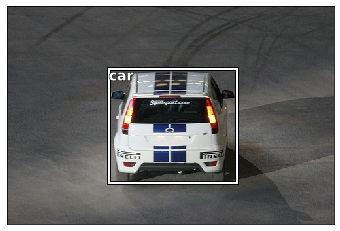

In [17]:
SAMPLE_FILE = '000012.jpg'
im = open_image(PATH / JPEGS / SAMPLE_FILE)
ax = show_img(im)
b = bb_to_voc(images[SAMPLE_FILE][0]['bb'])
draw_rect(ax, b)
draw_text(ax, b[:2], categories[images[SAMPLE_FILE][0]['category']])

Apply the model transformation to the random image, and then create a PyTorch Variable from it, requesting gradients for the image.

In [18]:
def draw_image(image, annotations):
    ax = show_img(image)
    for annotation in annotations:
        b = bb_to_voc(annotation['bb'])
        draw_rect(ax, b)
        draw_text(ax, b[:2], categories[annotation['category']])

Let's look at the model.

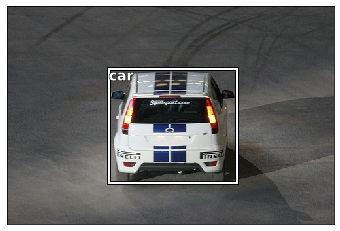

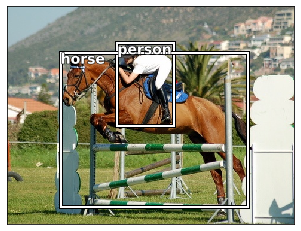

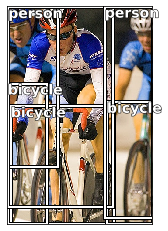

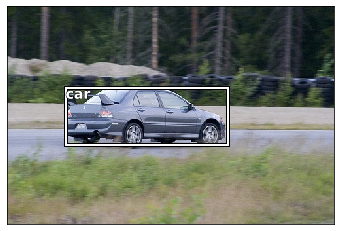

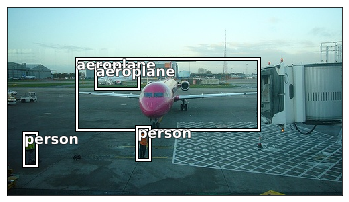

In [19]:
i = 0
for name, annotations in images.items():
    if i == 5:
        break
    i += 1
    draw_image(open_image(PATH/JPEGS/name), annotations)

## Classifier for largest object in image

First, let's set up the data correctly.

In [20]:
def largest_annotation(annotations):
    def area(a):
        bbox = a['bb']
        # Multiply width * height
        return np.prod(np.array(bbox[2:]) - np.array(bbox[:2]))
    return sorted(annotations, key=area)[-1]
largest_annotation(images['000012.jpg'])

{'bb': (96, 155, 270, 351), 'category': 7}

Our x is the image name. y is the desired category

In [21]:
file_and_cat = {'file': [], 'category': []}
for file, annotations in images.items():
    file_and_cat['file'].append(file)
    file_and_cat['category'].append(
        categories[largest_annotation(annotations)['category']])
df = pd.DataFrame(file_and_cat, columns=['file', 'category'])
df.to_csv('file_and_cat.csv', index=False)

Now, we can create a learner. 

In [22]:
arch=resnet34
sz=228
tfms = tfms_from_model(
    resnet34, sz, 
    aug_tfms=transforms_side_on, crop_type=CropType.NO, max_zoom=1.1
)
data_categories = ImageClassifierData.from_csv(PATH, JPEGS, 'file_and_cat.csv', tfms=tfms)
learn = ConvLearner.pretrained(arch, data_categories, precompute=True)
learn.opt_fn = optim.Adam

In [23]:
lrf=learn.lr_find(1e-5,100)

  3%|▎         | 1/32 [00:00<00:28,  1.10it/s, loss=3.77]


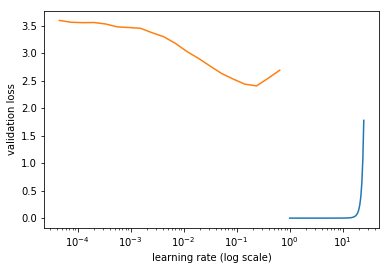

In [24]:
learn.sched.plot_lr()
learn.sched.plot(n_skip=3, n_skip_end=1)

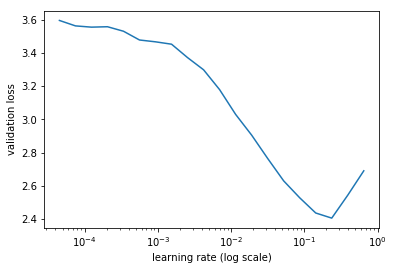

In [25]:
learn.sched.plot(n_skip=3, n_skip_end=1)

In [26]:
lr=0.1
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      2.872181   1.652101   0.738     



[array([1.6521]), 0.7379999995231629]

In [27]:
lrs = np.array([lr * 10e-2, lr * 10e-1, lr])
learn.freeze_to(-2)

We run the optimizer step function 1000 times. The parameter we pass in is a closure that does one step.
The call to ```partial``` does a partial evaluation of the ```step``` function; that is, it creates a new function which
is equivalent to calling ```step(content_loss)```.

In [28]:
learn.fit(lr/10, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.660586   1.068409   0.792     
    1      1.300607   0.998401   0.8       
    2      1.156479   0.859695   0.802     
    3      0.921567   0.831463   0.802     
    4      0.756154   0.772161   0.822     
    5      0.637405   0.785838   0.822     
    6      0.572218   0.832821   0.796     
    7      0.54374    0.793033   0.8       
    8      0.499409   0.794554   0.802     
    9      0.407928   0.804965   0.802     
    10     0.338231   0.822519   0.806     
    11     0.303081   0.825503   0.82      
    12     0.271216   0.798999   0.806     
    13     0.253636   0.798693   0.808     



[array([0.79869]), 0.8079999995231628]

In [29]:
x,y = next(iter(data_categories.val_dl))
probs = F.softmax(predict_batch(learn.models.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


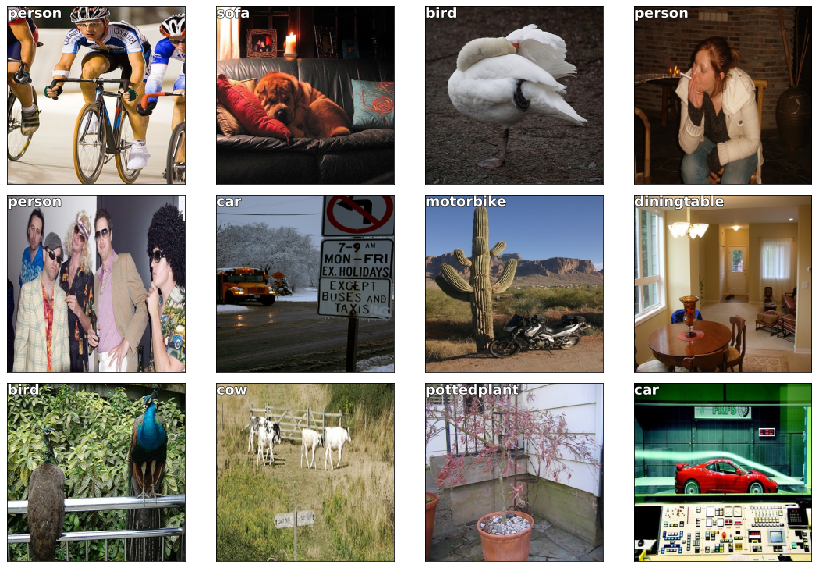

In [30]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=data_categories.val_ds.denorm(x)[i]
    b = data_categories.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## Predicting bounding box of largest object 

In [31]:
FILES_AND_BB_CSV = PATH/'tmp'/'files_and_bb.csv'

file_and_bb = {'fname': [], 'bb': []}
count = 0
for file, annotations in images.items():
    file_and_bb['fname'].append(file)
    file_and_bb['bb'].append(
        " ".join(map(str, largest_annotation(annotations)['bb'])))
    count = count + 1
    #if count > 9:
        #break # temporary; suport just one picture
df = pd.DataFrame(file_and_bb, columns=['fname', 'bb'])
#print(df.head())
df.to_csv(FILES_AND_BB_CSV, index=False)
FILES_AND_BB_CSV.open().readlines()[:4]

['fname,bb\n',
 '000012.jpg,96 155 270 351\n',
 '000017.jpg,77 89 336 403\n',
 '000023.jpg,1 2 462 243\n']

In [32]:
images['000012.jpg']

[{'bb': (96, 155, 270, 351), 'category': 7}]

Create a learner

In [33]:
arch=resnet34
sz=228
aug_tfms = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
tfms = tfms_from_model(
    resnet34, sz, 
    aug_tfms=aug_tfms,
    max_zoom=1.1,
    crop_type=CropType.NO, 
    tfm_y=TfmType.COORD
)
data_bb = ImageClassifierData.from_csv(PATH, JPEGS, FILES_AND_BB_CSV,
                                    tfms=tfms,
                                    continuous=True)
learn = ConvLearner.pretrained(arch, data_bb)
learn.opt_fn = optim.Adam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


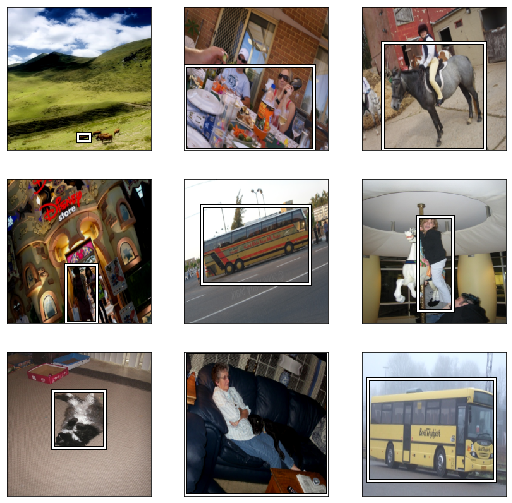

In [34]:
fig,axes = plt.subplots(3,3, figsize=(9,9))
#x,y=next(iter(data.trn_dl)) # assumes batch size is larger than axes
for i,ax in enumerate(axes.flat):
    x,y=next(iter(data_bb.trn_dl)) # assumes batch size is larger than axes
    ima=data_bb.val_ds.denorm(to_np(x))[i]
    b = bb_to_voc(to_np(y[i]))
    #print(y[i], b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [35]:
lrf=learn.lr_find(1e-5,100)

 94%|█████████▍| 30/32 [00:05<00:00,  8.01it/s, loss=258]


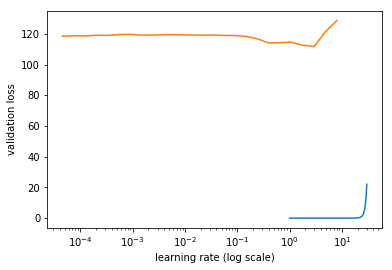

In [36]:
learn.sched.plot_lr()
learn.sched.plot(n_skip=3, n_skip_end=1)

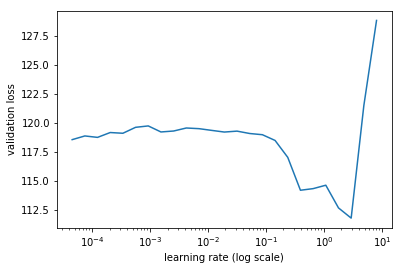

In [37]:
learn.sched.plot(n_skip=3, n_skip_end=1)

In [38]:
lr=0.1
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   
    0      52.57252   31.058057 



[array([31.05806])]

In [39]:
lrs = np.array([lr * 10e-2, lr * 10e-1, lr])
learn.freeze_to(-2)

In [40]:
learn.fit(lr/10, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      32.045574  39.038233 
 94%|█████████▍| 30/32 [00:08<00:00,  4.35it/s, loss=30.9]

KeyboardInterrupt: 

In [ ]:
x,y = next(iter(data_bb.val_dl))
x,preds = to_np(x),to_np(predict_batch(learn.models.model, x))
print(y[:5], preds[:5])

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=data_bb.val_ds.denorm(x)[i]
    bb = preds[i]
    ax = show_img(ima, ax=ax)
    b = bb_to_voc(preds[i])
    #print(b)
    draw_rect(ax, b)

plt.tight_layout()

## Learn both category and bounding box of largest object

In [41]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))
    
    @property
    def sz(self): return self.ds.sz
    
    @property
    def c(self): return self.ds.c

We'll reuse the datasets from the category and bounding box predictors

In [280]:
arch=resnet34
sz=224
bs=32
aug_tfms = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
        RandomLighting(0.05,0.05, tfm_y=TfmType.COORD)]
tfms = tfms_from_model(
    resnet34, sz, 
    aug_tfms=aug_tfms,
    max_zoom=1.1,
    crop_type=CropType.NO, 
    tfm_y=TfmType.COORD
)
data = ImageClassifierData.from_csv(PATH, JPEGS, FILES_AND_BB_CSV,
                                    tfms=tfms,
                                    continuous=True)
data_categories = ImageClassifierData.from_csv(PATH, JPEGS, 'file_and_cat.csv', 
                                               tfms=tfms # we won't actually be doing any transformations
                                              )


In [281]:
data.trn_dl.dataset = ConcatLblDataset(data.trn_ds, data_categories.trn_y)
data.val_dl.dataset = ConcatLblDataset(data.val_ds, data_categories.val_y)

In [283]:
x,y=next(iter(data.val_dl))
idx=1
ima=data.val_ds.ds.denorm(to_np(x))[idx]
print(y[:10])
b = bb_to_voc(to_np(y[0][idx])); b

[
    0    49   206   181
   63     1   222   223
   23    30   205   205
   38    52   222   159
   17   102   222   179
   92     0   143    74
  150    81   207   207
  159    19   222   124
    6   149   218   202
   53   136   109   170
    2     1   222   223
   95    53   138   182
  105   102   215   221
   22     6   218   197
   45    31   191   187
   53    15   214   222
   84   192   222   223
   49   116   214   196
   41    56   184   142
   16    72   144   166
   55    25   222   188
  106   173   186   208
   13     1   222   151
    1     7   222   222
   74    13   207   174
   34     9   166   203
   39   123   222   185
   69    26   144    69
  100    56   222   192
   26    38   160   200
   99    45   206   102
   65     5   136   220
   42    96   123   149
   54    37   184   191
   93    42   162   211
   48    32   175   147
  127     0   222   136
    0    11   128   171
   70   141   103   162
  131    24   218   196
  174   147   222   203
   48     9   

(1.0, 63.0, 222.0, 159.0)

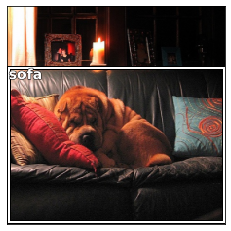

In [284]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], data_categories.classes[y[1][idx]])

In [ ]:
head_bwcat = nn.Sequential(
    Flatten(),
#    nn.ReLU(),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256,4+len(categories)),
)
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=head_bwcat)

learn = ConvLearner(data, models)
learn.opt_fn = optim.Adam

In [ ]:
def loss(input, target):
    target_bb, target_cat = target
    yhat_bb, yhat_cat = input[:, :4], input[:, 4:]
    # scale into range 0..sz
    #print('yhat before scaling:', yhat_bb[0])
    yhat_bb = F.sigmoid(yhat_bb)*sz

    #print('yhat:', yhat_bb[0], 'target: ', target_bb[0])
    loss_bb = F.l1_loss(yhat_bb, target_bb)
    loss_cat = F.cross_entropy(yhat_cat, target_cat)
    #print("bbox loss: ", loss_bb)
    #print("cat loss:", loss_cat)
    # I looked at bbox_loss and cat_loss and then picked a multiplier
    # to make them approximately equal
    return loss_bb + loss_cat*20
    return loss_bb #+ loss_cat*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = loss
#learn.metrics = [detn_acc, detn_l1]

In [235]:
lrf=learn.lr_find(1e-5,100)

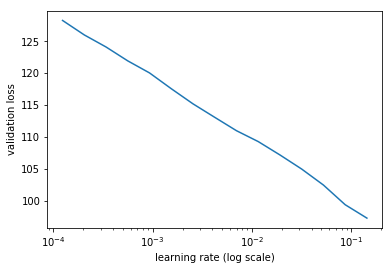

In [236]:
learn.sched.plot(5)

In [237]:
lr=0.1
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   
    0      74.29632   61.631429 
    1      56.401805  46.532657 
    2      43.827926  40.774589 


[array([40.77459])]

In [238]:
x,y = next(iter(data.val_dl))
x,yhat = to_np(x),to_np(predict_batch(learn.models.model, x))
print(yhat.shape)

(64, 24)


In [239]:
print(x.shape)

(64, 3, 224, 224)


In [240]:
print(yhat[0])

[-2.49824 -1.30341  3.77129  1.68834 -6.78045  6.46294 -3.32333 -6.19245 -2.99816 -6.67775 -3.59741 -4.60088
  1.78666 -2.79417  0.30241  0.91231  0.61744  2.96614 11.10077 -6.72757 -6.01299 -1.12117 -2.47347 -6.85989]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


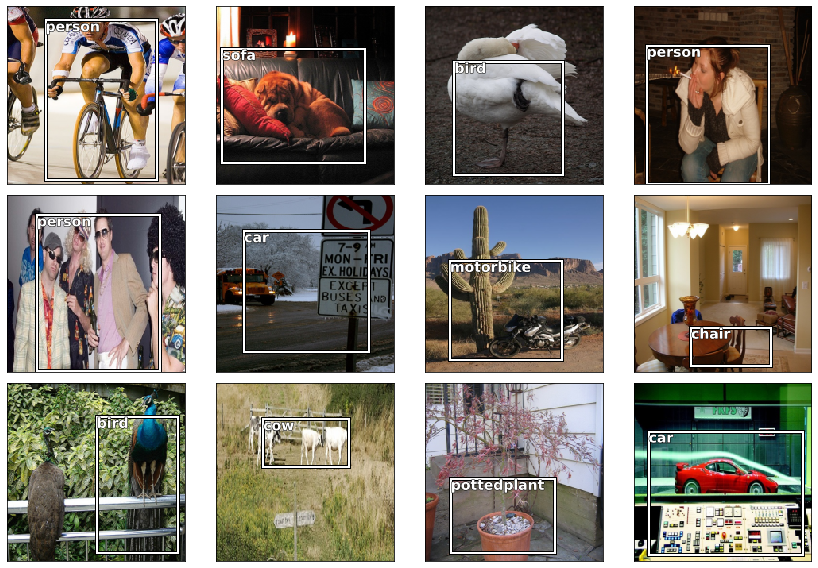

In [241]:
from scipy.special import expit
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.ds.denorm(x)[i]
    bb = expit(yhat[i][:4]) * sz
    ax = show_img(ima, ax=ax)
    b = bb_to_voc(bb)
    c = np.argmax(yhat[i][4:])
    draw_rect(ax, b)
    draw_text(ax, b[:2], data_categories.classes[c])
plt.tight_layout()

## Multiple objects

In [194]:
total_boxes = 9
n_clas = len(categories)+1
n_act = total_boxes*(4+n_clas)

In [195]:
head_bwcat = nn.Sequential(
    Flatten(),
#    nn.ReLU(),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256,n_act),
)
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=head_bwcat)

learn = ConvLearner(data, models)
learn.opt_fn = optim.Adam

We need to create a dataset mapping the image to the bounding boxes and categories. We create a separate dataset for the bounding boxes because those bounding boxes need transformations that the categories do not.

In [250]:
FILE_AND_BBS = 'file_and_bbs.csv'
FILE_AND_CATS = 'file_and_cats.csv'
file_and_bbs = {'file': [], 'bboxes': []}
file_and_cats = {'file': [], 'cats': []}
for file, annotations in images.items():
    file_and_bbs['file'].append(file)
    file_and_cats['file'].append(file)
    bboxes = ""
    cats = ""
    for annotation in annotations:
        bboxes += " " + " ".join(map(str, annotation['bb']))
        cats += " " + str(annotation['category'])
    file_and_cats['cats'].append(cats)
    file_and_bbs['bboxes'].append(bboxes)
df = pd.DataFrame(file_and_bbs, columns=['file', 'bboxes'])
df.to_csv(FILE_AND_BBS, index=False)
df = pd.DataFrame(file_and_cats, columns=['file', 'cats'])
df.to_csv(FILE_AND_CATS, index=False)

cats_list[:10]

[' 7',
 ' 15 13',
 ' 2 2 2 15 15 15',
 ' 7',
 ' 1 1 15 15',
 ' 1 1 1',
 ' 19 19',
 ' 15 15 15 11',
 ' 12',
 ' 19 19']

In [247]:
arch=resnet34
sz=224
bs=32
aug_tfms = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
        RandomLighting(0.05,0.05, tfm_y=TfmType.COORD)]
tfms = tfms_from_model(
    resnet34, sz, 
    aug_tfms=aug_tfms,
    max_zoom=1.1,
    crop_type=CropType.NO, 
    tfm_y=TfmType.COORD
)
data_bboxes = ImageClassifierData.from_csv(PATH, JPEGS, FILE_AND_BBS,
                                    tfms=tfms,
                                    continuous=True)
data_bboxes = ImageClassifierData.from_csv(PATH, JPEGS, FILE_AND_CATS,
                                    tfms=tfms,
                                    continuous=True)
data_categories = ImageClassifierData.from_csv(PATH, JPEGS, 'file_and_cat.csv', tfms=tfms)


RuntimeError: invalid argument 2: dimension 1 out of range of 0D tensor at /pytorch/torch/lib/TH/generic/THTensor.c:24

In [ ]:
data.trn_dl.dataset = ConcatLblDataset(data.trn_ds, data_categories.trn_y)
data.val_dl.dataset = ConcatLblDataset(data.val_ds, data_categories.val_y)